# Environment Setup

We start by importing the libraries and modules needed for this analysis.

In [1]:
# Import libraries

# For handling data and calculations
import os
import numpy as np
import pandas as pd
from collections import defaultdict 
from PIL import Image

# PyTorch modules for building, training, and evaluating neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# Torchvision modules for computer vison and image handling
import torchvision
from torchvision import datasets, transforms

# Metrics for evaluating model performance
import torchmetrics

# For displaying images, plotting metrics, etc.
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

# tqdm allows us to display a progress bar for long loops
from tqdm import tqdm 
tqdm.pandas()

# For displaying commands in each cell
from IPython.core.interactiveshell import InteractiveShell

# Display output of every command in a cell
InteractiveShell.ast_node_interactivity = 'all'

# Set the device on which to store torch tensors; if torch.cuda is available use gpu, otherwise use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:",device.type)

Using device: cuda


# Data Exploration

Prior to building the model, we explore the data. The dataset consists of images of different animals stored as JPEGs, with each animal grouped into one subfolder with the animal name (in Italian!). Let's start by studying the class distribution. Rather than read each JPEG, we will just count the number of files in each folder which will speed up the process.

In [2]:
# Root path to all images and
ROOT_PATH = '/kaggle/input/animals10/raw-img/'

# Path for all outputs
OUT_PATH = '/kaggle/working/'

# Since animal names are in italian we will have to translate into English
translate = {'cane': 'Dog', 
             'cavallo': 'Horse', 
             'elefante': 'Elephant', 
             'farfalla': 'Butterfly', 
             'gallina': 'Chicken', 
             'gatto': 'Cat', 
             'mucca': 'Cow', 
             'pecora': 'Sheep', 
             'ragno': 'Spider', 
             'scoiattolo': 'Squirrel'
            }

# Walk through the root dir and get the folder and file name for each image
paths, files = zip(*[(path[0], file) for path in os.walk(ROOT_PATH) for file in path[2]])

# Create pandas dataframe to store image path data
df_files = pd.DataFrame({'path': paths, 'file': files})

# Get the English name of the animal for each folder
df_files['label'] = df_files['path'].str.split('/').str[-1].apply(lambda x: translate[x])

# Group by label and sort by the size of the group
df_files = df_files.iloc[df_files.groupby('label').transform('size').argsort(kind='mergesort')].reset_index(drop=True)

# Inspect
df_files.info()
df_files.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    26179 non-null  object
 1   file    26179 non-null  object
 2   label   26179 non-null  object
dtypes: object(3)
memory usage: 613.7+ KB


,path,file,label
0,/kaggle/input/animals10/raw-img/elefante,OIP-QeF6RwJQuXjYWQOXa4PLGwHaE6.jpeg,Elephant
1,/kaggle/input/animals10/raw-img/elefante,OIP-GIzroxEWulvjZ6Me9KFSnwHaFj.jpeg,Elephant
2,/kaggle/input/animals10/raw-img/elefante,OIP--UnQR8C6k6T8rQuJOQ87QgHaFj.jpeg,Elephant
3,/kaggle/input/animals10/raw-img/elefante,eb3cb80d2ff2023ed1584d05fb1d4e9fe777ead218ac10...,Elephant
4,/kaggle/input/animals10/raw-img/elefante,OIP-Lbhfmoj1wIbVE55UJcTWhAHaFm.jpeg,Elephant


We know the dataset contains 26179 images. Let's get a visualization of the class distribution in the dataset.

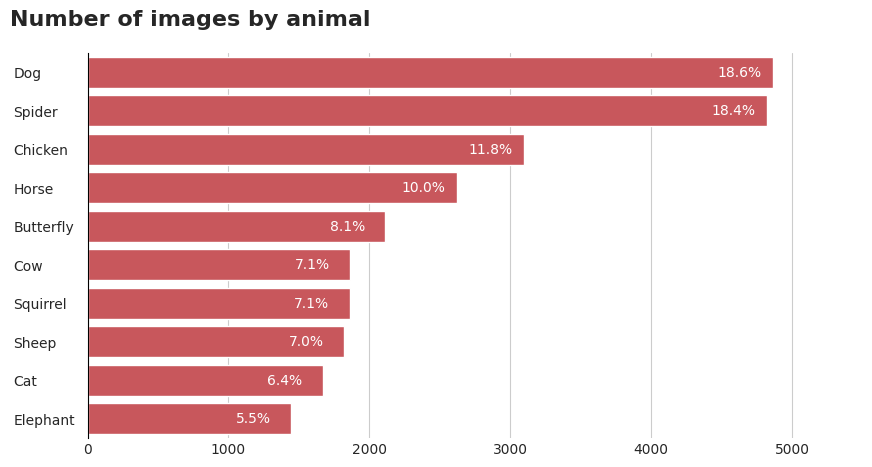

In [3]:
# Plot the file counts and percentages

# Set seaborn style
sns.set_style('whitegrid')

# Define color mapping
color_map = {'red': '#DB444B',
             'blue': '#006BA2', 
             'green': '#379A8B',
             'magenta': '#D23EBC', 
             'cyan': '#3EBCD2', 
             'yellow': '#EBB434', 
             'purple': '#9A607F',
             'olive': '#B4BA39',  
             'gold': '#D1B07C', 
             'gray': '#758D99', 
            }

label_map = {'Dog': 'red', 
             'Spider': 'blue', 
             'Chicken': 'gold', 
             'Horse': 'magenta', 
             'Butterfly': 'cyan', 
             'Cow': 'yellow', 
             'Squirrel': 'purple', 
             'Sheep': 'olive', 
             'Cat': 'green', 
             'Elephant': 'gray'
            }

# Create the figure and axes
fig, ax = plt.subplots(1, figsize=(10,5))

df_counts = df_files['label'].value_counts()
df_fracs = df_files['label'].value_counts(normalize=True)

# Plot the image counts for each animal as a horizontal bar chart (override colormap - we only need one color)
sns.barplot(x=df_counts.values, y=df_counts.index, orient='h', color=color_map['red'], zorder=2)

# Set the chart title
ax.set_title('Number of images by animal', weight='bold', fontsize=16, loc='left', x=-0.1, y=1.05)

# Annotate bars with the percentage
percent_labels = [f'{100*p:.1f}%' for p in df_fracs]
ax.bar_label(ax.containers[0], labels=percent_labels, label_type='edge', fontsize=10, color='white', padding=-40)

# Set x-axis range
ax.set_xlim([0, 5500])

# Remove x- and y-axis labels
ax.set(ylabel=None, xlabel=None)

# Set the color and padding of the tick labels
ax.tick_params(axis='x', pad=0)
ax.tick_params(axis='y', pad=50)  

# Left-align the y-axis tick labels
ax.set_yticklabels(ax.get_yticklabels(), ha='left')

# Remove y-axis grid lines
ax.yaxis.grid(False)

# Remove all but left spine, set color to black
ax.spines[['right','top', 'bottom']].set_visible(False)
ax.spines[['left']].set_color('black')

# Save the figure
plt.savefig(os.path.join(OUT_PATH,'filecounts.pdf'), bbox_inches='tight');

The classes are not uniformly distributed. Images of dogs and spiders make up 37% of the dataset in almost equal portions, while the rest of the animals each constitute between 5-10% of the dataset. To reduce training bias toward dogs and spiders, we could use a subset of the data for training with an equal number of images for each animal.

Now let's inspect the contents of the individual files, i.e., let's study the images' spatial dimensions and display a few images to confirm the class labels are consistent.

In [4]:
# Open up each image as a PIL and get the size, returning the height and width as two new columns in the df
df_files[['image_height','image_width']] = df_files.progress_apply(lambda x: Image.open(os.path.join(x.path, x.file)).size, axis=1, result_type='expand')

100%|██████████| 26179/26179 [02:20<00:00, 186.95it/s]


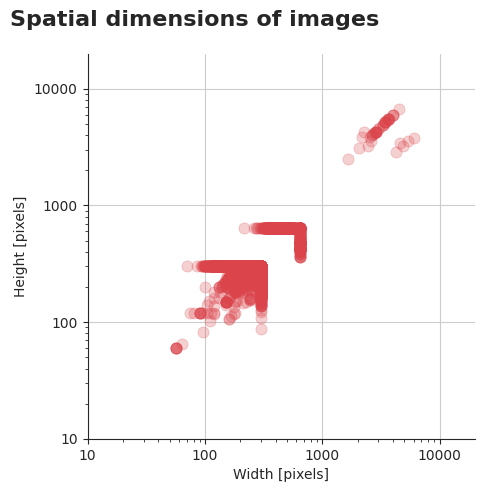

In [5]:
# Plot the different image dimensions and their frequencies

# Set seaborn style
sns.set_style('ticks')

# Create the figure and axes
fig, ax = plt.subplots(1, figsize=(5,5))

# Plot data as scatter plot with translucent markers
sns.scatterplot(data=df_files, x='image_width', y='image_height', alpha=0.25, color=color_map['red'], edgecolor=None, s=64, zorder=3) 

# Set the chart title
ax.set_title('Spatial dimensions of images', weight='bold', fontsize=16, loc='left', pad=20, x=-0.2)

# Set x- and y-axis to log scale
ax.set_yscale('log')
ax.set_xscale('log')

# Set x- and y-axis ranges
ax.set_ylim([10, 19999])
ax.set_xlim([10, 19999])

# Set x- and y-axis labels
ax.set_ylabel('Height [pixels]')
ax.set_xlabel('Width [pixels]')

# Add x- and y-axis grid lines
ax.grid()

# Remove scientific notation of ticks on x- and y-axis
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())

# Remove top and right spines
ax.spines[['right','top']].set_visible(False)

# Save the figure
plt.savefig(os.path.join(OUT_PATH,'imagedims.pdf'), bbox_inches='tight');

The image dimensions widely vary but are clustered into three groups: widths/heights between 50 and 300 pixels, which is where most of the data appear; widths/heights between 600 and 700 pixels; and a small collection of outliers with very large resolution over 1000 x 1000 pixels. We will use this figure to guide how we crop the images, since every tensor representing an image must be uniform in size among the input data when training and evaluating the model. Let's take a closer look at the distribution without the outliers.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


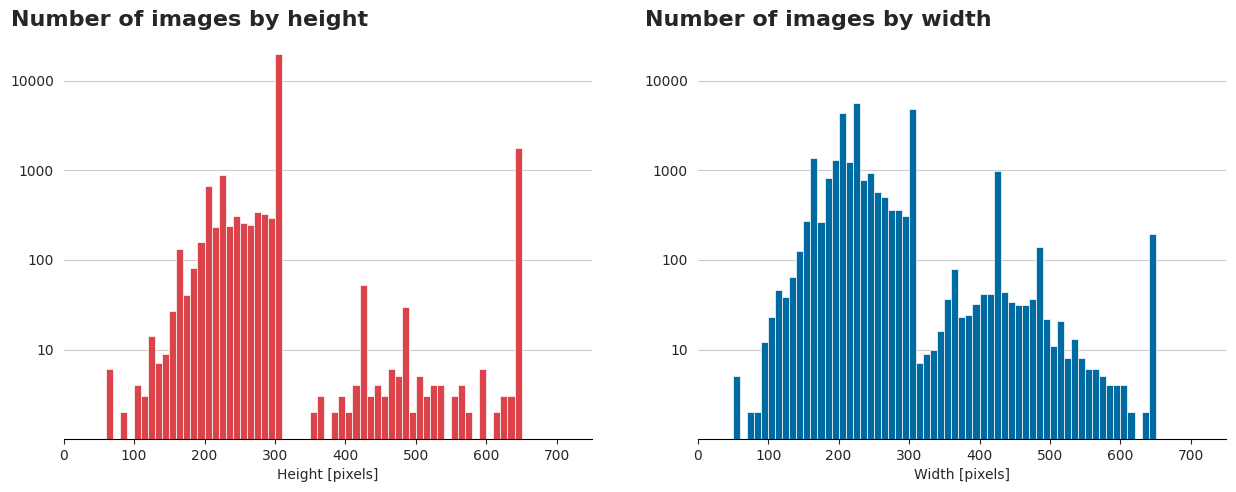

In [6]:
# Plot the different image dimensions and their frequencies

# Set seaborn style
sns.set_style('ticks')

# Create the figure and axes
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# Plot data as histograms
sns.histplot(data=df_files, x='image_height', bins=70, binrange=[0,700], color=color_map['red'], alpha=1, zorder=2, ax=ax[0]) 
sns.histplot(data=df_files, x='image_width', bins=70, binrange=[0,700], color=color_map['blue'], alpha=1, zorder=2, ax=ax[1]) 

# Set the chart title
ax[0].set_title('Number of images by height', weight='bold', fontsize=16, loc='left', pad=20, x=-0.1)
ax[1].set_title('Number of images by width', weight='bold', fontsize=16, loc='left', pad=20, x=-0.1)

# Set x- and y-axis to log scale
ax[0].set_yscale('log')
ax[1].set_yscale('log')

# Set x- and y-axis ranges
ax[0].set_ylim([1.01, 19999])
ax[1].set_ylim([1.01, 19999])
ax[0].set_xlim([0, 750])
ax[1].set_xlim([0, 750])

# Set x-axis labels and remove y-axis labels
ax[0].set_ylabel(None)
ax[1].set_ylabel(None)
ax[0].set_xlabel('Height [pixels]')
ax[1].set_xlabel('Width [pixels]')

# Remove y-axis ticks
ax[0].tick_params(which='both', left=False)
ax[1].tick_params(which='both', left=False)

# Remove scientific notation of ticks on y-axis
ax[0].yaxis.set_major_formatter(ScalarFormatter())
ax[1].yaxis.set_major_formatter(ScalarFormatter())

# Add y-axis grid lines
ax[0].yaxis.grid()
ax[1].yaxis.grid()

# Remove all but bottom spine, set color to black
ax[0].spines[['right','left','top']].set_visible(False)
ax[0].spines['bottom'].set_color('black')

ax[1].spines[['right','left','top']].set_visible(False)
ax[1].spines['bottom'].set_color('black')

# Save the figure
plt.savefig(os.path.join(OUT_PATH,'hist_imagedims.pdf'), bbox_inches='tight');

I think it is clear from these histograms that fixing images to 300 x 300 pixels will require the fewest transformations. To ensure every image is 300 x 300 pixels, we apply two transformations:
1. Pad each side of every image with a zero-valued/black 300-pixel-wide border
2. Center-crop each padded image to a 300 x 300 pixel grid

These transformations will minimize the amount of padding for the smaller images and minimize loss of information when cropping the larger images. 

Now we'll plot a few transformed images loaded as tensors with torchvision. This is a sanity check to see that the image data are appropriate, the transforms are applied, and the class labels are correct.

In [7]:
# Define the transforms to perform on each image, for now just convert PIL to tensor
IMAGE_SIZE = 300
input_transforms = transforms.Compose([transforms.ToTensor(), # Convert image to tensor
                                       transforms.Pad(IMAGE_SIZE),
                                       #transforms.Resize(IMAGE_SIZE, antialias=True), # Resize images so there is no padding after cropping
                                       transforms.CenterCrop(IMAGE_SIZE) # Crop so input tensors have the same dimension
])

# The ImageFolder class does not read any images into memory
# It will only read and load image files when we access an element
dataset = datasets.ImageFolder(ROOT_PATH, transform=input_transforms)

# Confirm size of dataset
len(dataset)

# Get label mapping (and translate)
dataset.class_to_idx
label_to_idx = {translate[class_ita]: idx for class_ita, idx in dataset.class_to_idx.items()}
idx_to_label = {idx: translate[class_ita] for class_ita, idx in dataset.class_to_idx.items()}

# Inspect one image and get the shape
image, class_idx = dataset[0]
image.shape

26179

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

torch.Size([3, 300, 300])

In [8]:
# Split dataset into training and testing (dataset size = 26179)
train_dataset, test_dataset = random_split(dataset, [21179, 5000]) # roughly 80/20 split

# Set the batch size
BATCH_SIZE = 16

# Create and fill dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

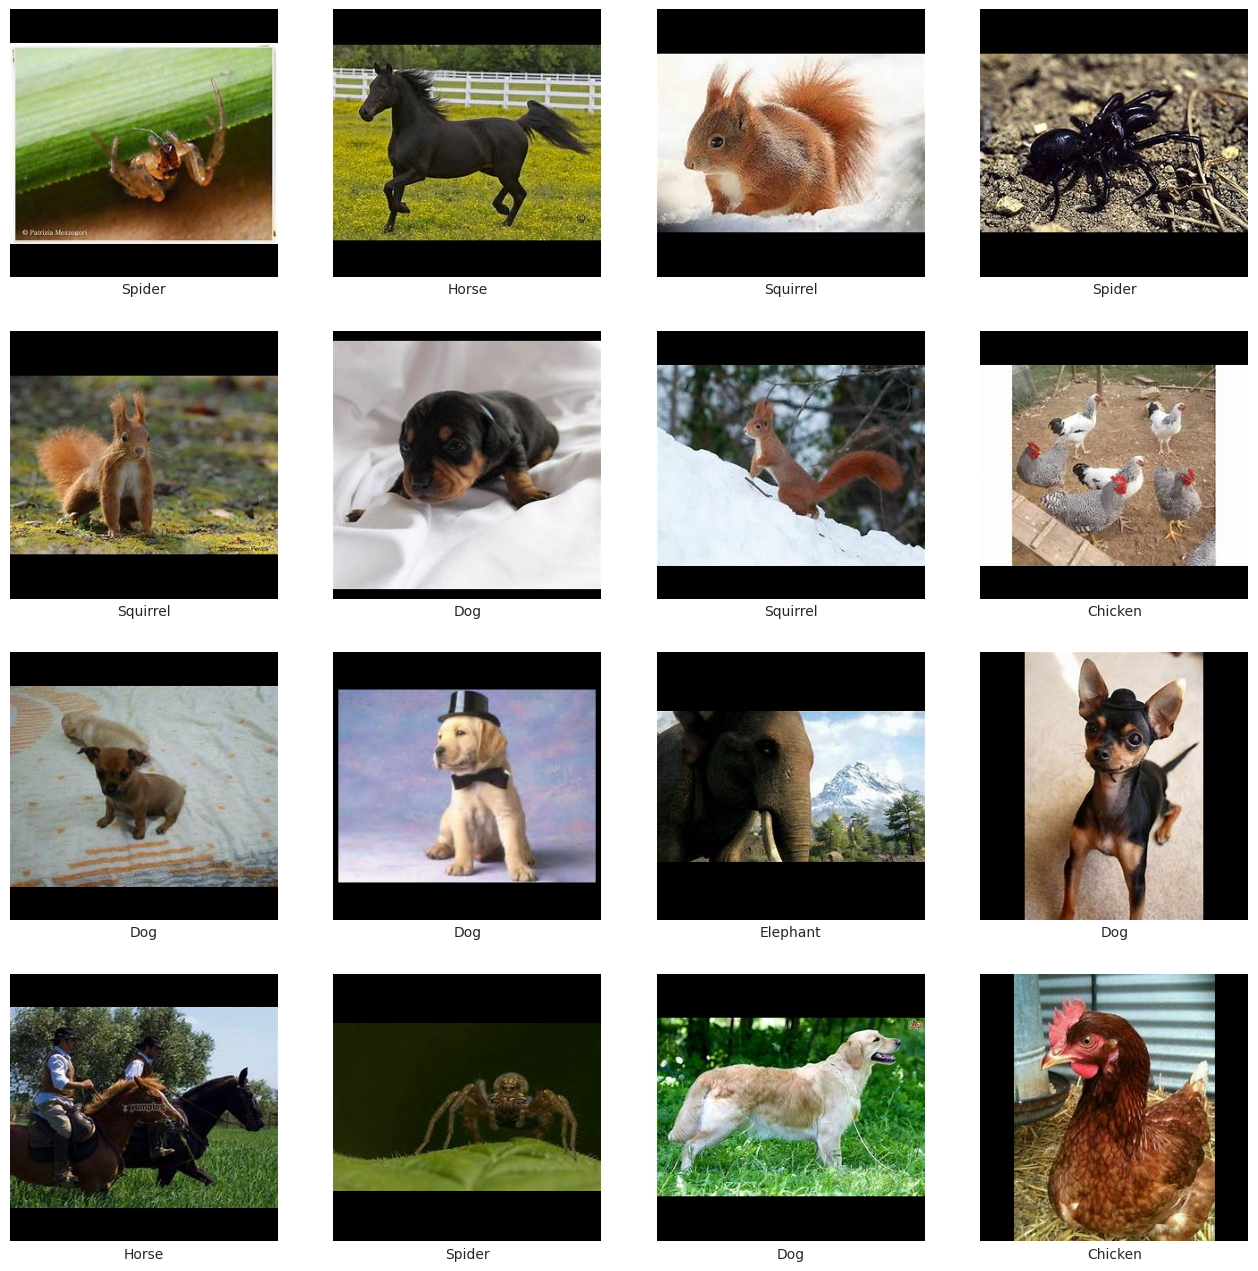

In [9]:
# Inspect the data to validate transformations, labels, etc.,

# Grab the first batch of data
features, labels = next(iter(train_dataloader))

# Plot the tensor with labels
sns.set_style('white')

# Create 4x4 subplot
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,16))

# Plot images in loop
for row in range(4):
    for col in range(4):
        idx = 4*row+col
        
        # Tensors are of dimension (channel, width, height) but to plot we want (width, height, channel), so permute the dimensions
        ax[row, col].imshow(features[idx].permute(1, 2, 0))
        
        # Add class labels (in English) as x-axis labels
        ax[row, col].set_xlabel(idx_to_label[labels[idx].item()])
        
        # Remove tick labels
        ax[row, col].tick_params(which='both', axis='both', labelleft=False, labelbottom=False)
        
        # Remove spines
        ax[row, col].spines[['right','left','top', 'bottom']].set_visible(False)
        
# Save the figure
plt.savefig(os.path.join(OUT_PATH,'image_label_sample.pdf'), bbox_inches='tight');

By inspection, we can confirm the labels appropriately match the animal depicted in the corresponding image. 

# Building the Neural Network

Now we will build the model and specify the hyperparameters. 



The model we will use is a Convolutional Neural Network (CNN). Our model will subclass `Module` from the `torch` library and consist of:

* One convolution layer with a 12 x 12 kernel and a stride of 1
* One 2 x 2 pooling layer with 6 features
* A second convolution layer with a 12 x 12 kernel and a stride of 1
* A second 2 x 2 pooling layer with 12 features
* Three fully-connected layers with sizes: 100 x 50, 50 x 20, and 20 x 10
* All convolution and fully-connected layer logits are passed through the ReLu activation function
* The final 1 x 10 dimensional output layer is passed through the softmax function

In [10]:
# Now build the image classifier with a Convolutional Neural Network (CNN)

class ImageClassifier(nn.Module):
    '''Convolutional Neural Network for classifying images into 1 of 10 classes.'''
    
    def __init__(self):
        '''Initialize the CNN and define the layers.'''
        super().__init__()
        
        # Input -> 3 x 300 x 300 (RBG channels, pixel height, pixel width)
        
        self.conv1 = nn.Conv2d(3, 6, 5) 
        
        # Conv1 -> 6 x 296 x 296 : where ((300 - 5)/1) + 1 = 296
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Pool1 -> 6 x 148 x 148 : where ((296 - 2)/2) + 1 = 148
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Conv2 -> 16 x 144 x 144 : where ((144 - 5)/1) + 1 = 144
        
        # Pool2 -> 16 x 72 x 72 : where ((144 - 2)/2) + 1 = 72
        
        # flatten -> 82944 : where 16 * 72 * 72 = 82944
        
        # Fully-connected layers
        self.fc1 = nn.Linear(16 * 72 * 72, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        '''Forward propogation of image through model.'''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1) # flatten dimensions (start_dim=1 to keep batches)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1) 
        return x


model = ImageClassifier().to(device)
model

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

We will start by training 2 epochs with a learning rate of 0.001 and momentum of 0.9.

In [11]:
# Set the training hyperparameters
EPOCHS = 10 # number of gradient descent passes in the model fitting
LEARNING_RATE = 0.001 # size of each step in gradient descent procedure
MOMENTUM = 0.9 # Momentum, speeds up training

Now we will decide how the model will be trained. We need to select a loss function: the metric by which to measure if the model has improved or worsened after adjusting the weights and biases. We also need to select an optimizer: a `torch` object that will store the model state, compute and the gradients (backpropgation) and updates the model weights.

For the loss function we will use `CrossEntropyLoss` which is a function used when building a classifier.

For the optimizer we will use `StochasticGradientDescent` that will perform stochastic gradient descent when computing the gradients.

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

accuracy_metric = torchmetrics.Accuracy(task="multilabel", num_labels=10).to(device)
confusion_metric = torchmetrics.ConfusionMatrix(task="multilabel", num_labels=10).to(device)

In [16]:
# Fitting procedure for a single epoch
def FitModel(dataloader, model, loss_fn, optimizer, epoch=0):

    total_loss = 0.0
    running_loss = 0.0

    # Set model to training mode
    model.train()

    # loop through training data one mini-batch at a time
    for minibatch, data in enumerate(dataloader):

        # Get input and label data for the current batch
        inputs, targets = data
        
        # Convert target indices to one-hot tensors
        targets = F.one_hot(targets, num_classes=10).float()
        
        # move tensors from cpu to gpU
        if device.type == 'cuda':
            inputs, targets = inputs.cuda(), targets.cuda()

        # Zero-out the parameter gradients before forward propogating
        optimizer.zero_grad()

        # Pass the input data forward through the model and get the predictions
        predictions = model(inputs)
        
        # Compute the accuracy for this mini-batch
        accuracy = accuracy_metric(predictions, targets)

        # Compute the loss by comparing the predictions with the targets
        # We need to on-hot encode the class labels to compare with the predictions
        loss = loss_fn(predictions, targets)
        
        # Incriment the total and running losses
        total_loss += loss.item()/len(dataloader)
        running_loss += loss.item()/50
        
        # Compute the gradients of the loss function
        # by back-propagating each operation performed by the model
        loss.backward()

        # Modify the learning weights such that the gradient is minimized
        optimizer.step()
        
        # For tracking progress every 2000 mini-batches
        if minibatch % 50 == 49:
            print(f'epoch: {epoch+1} | mini-batch: {minibatch+1} | loss: {running_loss / 50}')
            
            # Reset the running loss
            running_loss = 0.0

    return total_loss

# Evaluation loop - can be used on any dataset
def EvaluateModel(dataloader, model, loss_fn):
    
    total_loss = 0.0
    running_loss = 0.0

    # Set model to eval mode
    model.eval()

    # Evaluate model without computing gradients
    with torch.no_grad():

        # loop through data one batch at a time
        for minibatch, data in enumerate(dataloader):

            # Get input and label data for the current batch
            inputs, targets = data
            
            # Convert target indices to one-hot tensors
            targets = F.one_hot(targets, num_classes=10).float()
            
            # move tensors from cpu to gpu
            if device.type == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()

            # Pass the input data through the model and get the predictors
            predictions = model(inputs)
            
            # Get the loss function of the validation set
            loss = loss_fn(predictions, targets)
            total_loss += loss.item()/len(dataloader)
            running_loss += loss.item()/50

            # compute the accuracy for this batch
            accuracy = accuracy_metric(targets, targets)
            
            # compute the confusion matrix for this batch
            confusion_matrix = confusion_metric(predictions, targets.long())
            
            # For tracking progress every 2000 mini-batches
            if minibatch % 50 == 49:
                print(f'epoch: {epoch+1} | mini-batch: {minibatch+1} | loss: {running_loss / 50}')
            
                # Reset the running loss
                running_loss = 0.0
            
    return total_loss